# Point Transformer
https://github.com/qq456cvb/Point-Transformers

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from tqdm import tqdm

In [3]:
%load_ext tensorboard

In [4]:
import torch
!pip install open3d 1>/dev/null

In [5]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import torch.optim as optim
import numpy as np
from google.colab import output
output.enable_custom_widget_manager()

!pip install ipympl 1>/dev/null
%matplotlib widget

import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'
from pytorch3d.loss.chamfer import chamfer_distance

In [6]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes


In [7]:
# !git pull

In [8]:
from visuals.visuals_util import visualize_pointcloud_eval, visualize_pointcloud_eval_three

## Load dataset

In [9]:
from datasets.shapenet_data_pc import ShapeNet15kPointClouds

In [10]:
shapenet_location = "/content/gdrive/MyDrive/Developer/ShapeNetCore_pointclouds/ShapeNetCore.v2.PC15k"
tr_dataset = ShapeNet15kPointClouds(root_dir=shapenet_location,
    categories=["airplane"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

val_dataset = ShapeNet15kPointClouds(root_dir=shapenet_location,
    categories=["airplane"], split='val',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

test_dataset = ShapeNet15kPointClouds(root_dir=shapenet_location,
    categories=["airplane"], split='test',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

len(tr_dataset), len(val_dataset), len(test_dataset)

Total number of data:2832
Min number of points: (train)2048 (test)2048
Total number of data:405
Min number of points: (train)2048 (test)2048
Total number of data:808
Min number of points: (train)2048 (test)2048


(2832, 405, 808)

In [27]:
train_dataloader = torch.utils.data.DataLoader(tr_dataset,
                                               batch_size=5,
                                               sampler=None,
                                               shuffle=True is None,
                                               num_workers=1,
                                               drop_last=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                               batch_size=5,
                                               sampler=None,
                                               shuffle=True is None,
                                               num_workers=1,
                                               drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=5,
                                               sampler=None,
                                               shuffle=True is None,
                                               num_workers=1,
                                               drop_last=True)

In [12]:
def add_random_noise(point_cloud, mean=0, std=0.025):
    noise = torch.normal(mean, std, size=point_cloud.size()).to("cuda")
    point_cloud_noise = point_cloud + noise
    return point_cloud_noise

In [13]:
from pytorch3d.loss.chamfer import chamfer_distance

In [44]:
# Debug
import torch

def own_chamfer_distance(point_cloud1, point_cloud2):
    """
    Compute the Chamfer Distance between two point clouds.

    Parameters:
    - point_cloud1: A tensor of shape (N, 1024, 3)
    - point_cloud2: A tensor of shape (N, 1024, 3)

    Returns:
    - A tensor containing the Chamfer Distance for each pair of point clouds.
    """
    N, P, _ = point_cloud1.shape  # Assume point_cloud1 and point_cloud2 have the same shape

    # Expand dims to (N, P, 1, 3) for broadcasting
    point_cloud1_expanded = point_cloud1.unsqueeze(2)
    point_cloud2_expanded = point_cloud2.unsqueeze(1)

    # Compute squared distances (N, P, P)
    dists = torch.sum((point_cloud1_expanded - point_cloud2_expanded) ** 2, dim=-1)

    # Minimum along one axis (N, P)
    min_dists1 = torch.min(dists, dim=2)[0]  # (N, P)
    min_dists2 = torch.min(dists, dim=1)[0]  # (N, P)

    # Average minimum distance
    chamfer_dist = torch.mean(min_dists1, dim=1) + torch.mean(min_dists2, dim=1)

    return chamfer_dist

# Example usage
pc1 = torch.rand(10, 1024, 3)  # Random point cloud 1
pc2 = torch.rand(10, 1024, 3)  # Random point cloud 2

print(own_chamfer_distance(pc1, pc2).mean(), chamfer_distance(pc1, pc2))


tensor(0.0074) (tensor(0.0074), None)


In [14]:
def residuals_chamfer_distance(input, output):
  # return own_chamfer_distance(input, input + output)
  return chamfer_distance(input, input + output)[0]

In [46]:
example_input = tr_dataset[0]["train_points"]
example_batch = example_input.unsqueeze(0)
example_zeros = torch.zeros(example_batch.shape)
print((example_input + example_zeros).shape)
print(own_chamfer_distance(example_batch, example_zeros))
print(residuals_chamfer_distance(example_batch, example_zeros))

torch.Size([1, 2048, 3])
tensor([5.3150])
tensor(0.)


## Load model

In [15]:
%cd /content/gdrive/MyDrive/Developer
# !git clone https://github.com/qq456cvb/Point-Transformers
%cd Point-Transformers

/content/gdrive/MyDrive/Developer
/content/gdrive/MyDrive/Developer/Point-Transformers


In [ ]:
!pip install -r requirements.txt

### Point Transformer Model

In [26]:
from models.Hengshuang.model import PointTransformerSeg

class DotDict:
  pass

cfg = DotDict()
cfg.num_point = 2048
cfg.model = DotDict()
cfg.model.nneighbor=64
cfg.model.nblocks=1
cfg.model.transformer_dim=128
cfg.num_class=3
cfg.input_dim = 3

model = PointTransformerSeg(cfg)

# Losses
training_losses = []
val_losses = []
linearize_input = False

## Overfit model as an autoencoder on a batch of point clouds



In [18]:
print(f"cuda available: {torch.cuda.is_available()}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)
!nvidia-smi
# for param in model.parameters():
#   param.to(device)

cuda available: True
cuda:0
Sun Jan 28 15:21:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              41W / 300W |    312MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+---------------------------------------

In [32]:
# TensorBoard Logging with model's name and current date
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
model_name = 'PointTransformer-pip-gup'
log_dir = f"runs/{model_name}_{current_time}"
writer = SummaryWriter(log_dir=log_dir)

# Losses
training_losses = []
val_losses = []

# Early Stopping (patience)
best_val_loss = np.inf
patience = 10
patience_counter = 0

In [20]:
# Optimization
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)

In [ ]:
%tensorboard --logdir runs

In [22]:
from torch.utils.viz._cycles import warn_tensor_cycles
warn_tensor_cycles()()

In [23]:
import gc

# del input
# del noised_input
# del model
torch.cuda.empty_cache()  # Clear cache
gc.collect()  # Garbage collection
!nvidia-smi

Sun Jan 28 15:21:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              41W / 300W |    312MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [27]:
dummy_input = next(iter(train_dataloader))["train_points"].to(device)

writer.add_graph(model, dummy_input)

/content/gdrive/MyDrive/Developer/Point-Transformers/pointnet_util.py:289: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if S == 1:
/usr/local/lib/python3.10/dist-packages/torch/jit/_trace.py:1093: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 28937 / 30720 (94.2%)
Greatest absolute difference: 0.0016536898910999298 at index (0, 1273, 1) (up to 1e-05 allowed)
Greatest relative difference: 0.1030615703311652 at index (4, 665, 1) (up to 1e-05 allowed)
  _check_trace(


In [29]:
_ = model.to(device)

In [44]:
import itertools
for batch in itertools.islice(train_dataloader, 10):
  print(batch["train_points"].size)

<built-in method size of Tensor object at 0x7c7fe6b7f790>
<built-in method size of Tensor object at 0x7c7fe6b97a10>
<built-in method size of Tensor object at 0x7c7fe6b96700>
<built-in method size of Tensor object at 0x7c7fe6b97c90>
<built-in method size of Tensor object at 0x7c7fe6b97f10>
<built-in method size of Tensor object at 0x7c7fe6b96200>
<built-in method size of Tensor object at 0x7c7fe6b94a90>
<built-in method size of Tensor object at 0x7c7fe6b7e2f0>
<built-in method size of Tensor object at 0x7c7fe6b97dd0>
<built-in method size of Tensor object at 0x7c803045b650>


In [ ]:
# Time to train
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes

for epoch in range(100):
    total_train_loss = 0
    total_val_loss = 0

    # Train
    model.train()
    for batch in itertools.islice(train_dataloader, 10):
        input = batch["train_points"].to(device)

        noised_input = add_random_noise(input)

        optimizer.zero_grad()
        output_batch = model(noised_input)

        loss = residuals_chamfer_distance(input, output_batch).mean()
        # print(loss.shape, loss)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    epoch_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(epoch_train_loss)

    # Epoch is done; Reduce LR
    # lr_scheduler.step()

    # Validate
    model.eval()
    with torch.no_grad():
        for batch in itertools.islice(val_dataloader, 5):
            input = batch["train_points"].to(device)

            # Let's first add noise
            noised_input = add_random_noise(input)

            output_batch = model(noised_input)

            val_loss = residuals_chamfer_distance(input, output_batch).mean()

            total_val_loss += val_loss.item()

    epoch_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(epoch_val_loss)

    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)

    print(f"Epoch {epoch+1},  Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

    # Check for improvement
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0  # reset the patience counter
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epochs.")

    # Break the loop if patience exceeded
    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break

    # Save the model
    model_save_path = f"output-models/point_transformer/point_transformer_pip_noise_epoch-{epoch+1}.pth"
    torch.save(model.state_dict(), model_save_path)


writer.close()

In [ ]:
# import torch
# import gc

# for obj in gc.get_objects():  # Iterate through all objects
#   try:
#     if torch.is_tensor(obj) and obj.is_cuda:  # Filter for tensors on the GPU
#       mb = obj.element_size() * obj.nelement() / 1e6
#       if mb > 1.0:
#         print(f"Type: {type(obj)}, Size: {obj.size()}, Device: {obj.device}, Memory: {mb} MB")
#   except Exception as e:
#     pass
# torch.cuda.empty_cache()  # Clear cache
# gc.collect()  # Garbage collection

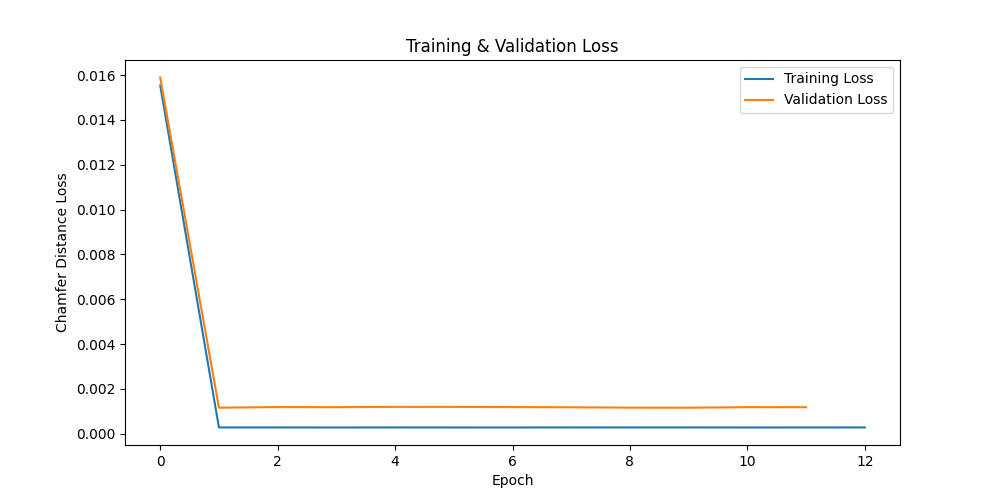

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Chamfer Distance Loss')
plt.legend()
plt.show()

## Visualize example

In [ ]:
next(iter(train_dataloader))["test_points"]

In [58]:
model.eval()
test_batch = next(iter(train_dataloader))["test_points"].to(device)
with torch.no_grad():
  test_output_batch = model(test_datapoint)

In [59]:
print(input.shape, output.shape, (input + output).shape)
print(chamfer_distance(input, output)[0], residuals_chamfer_distance(input, output))

torch.Size([5, 2048, 3]) torch.Size([5, 2048, 3]) torch.Size([5, 2048, 3])
tensor(2.1409, device='cuda:0') tensor(0.0140, device='cuda:0')


In [60]:
print(output.mean(), output.std(), output.min(), output.max())

tensor(-0.0478, device='cuda:0') tensor(0.1057, device='cuda:0') tensor(-0.5942, device='cuda:0') tensor(0.2510, device='cuda:0')


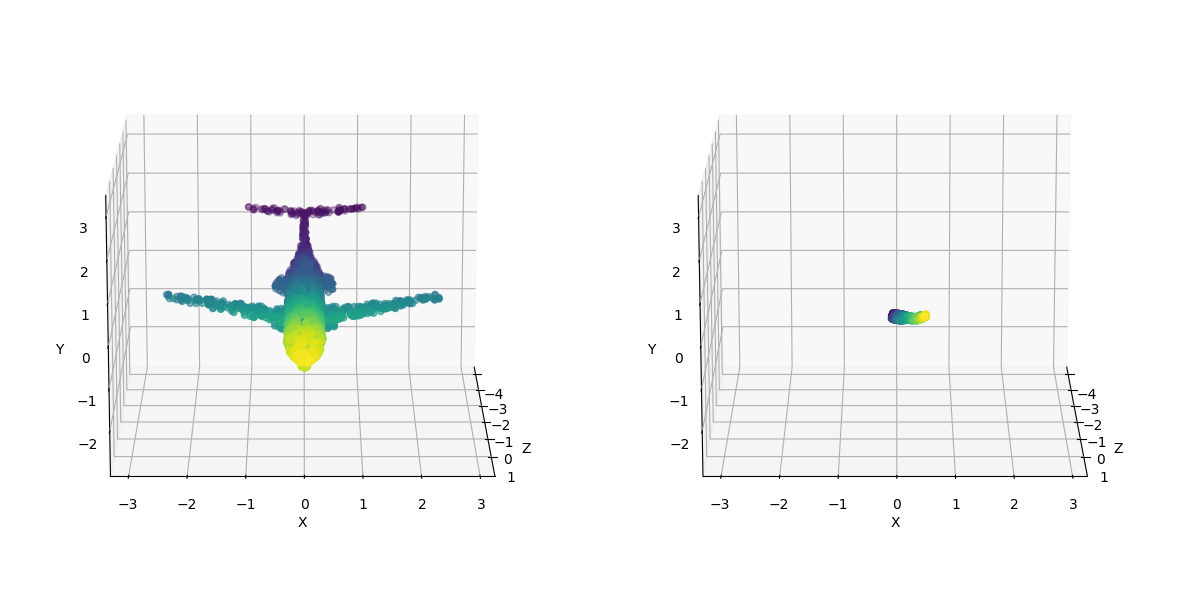

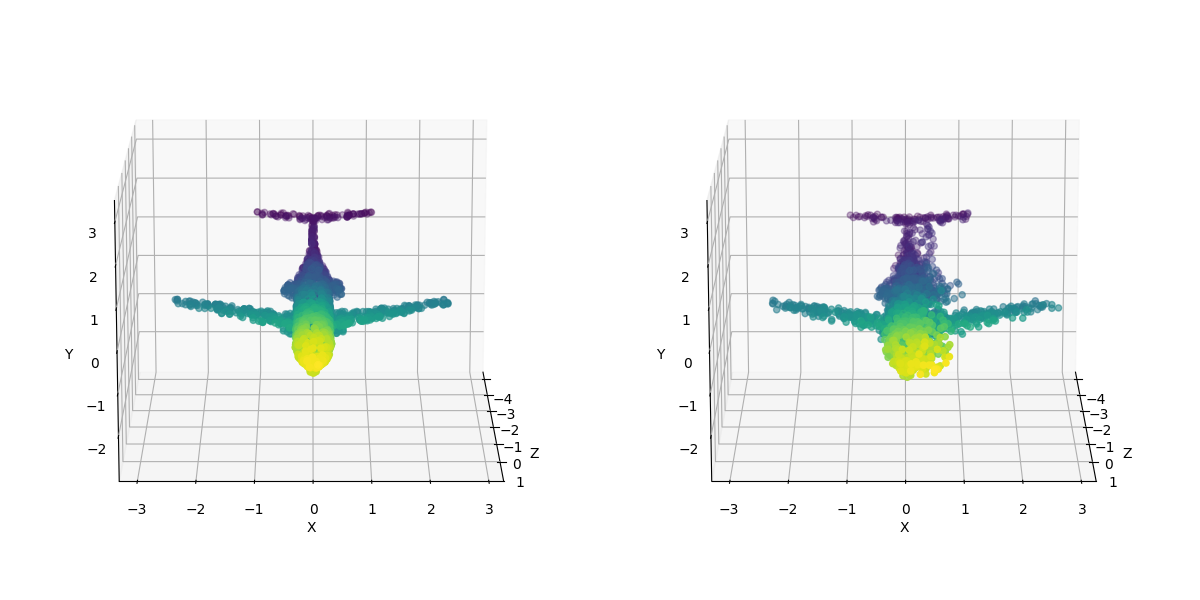

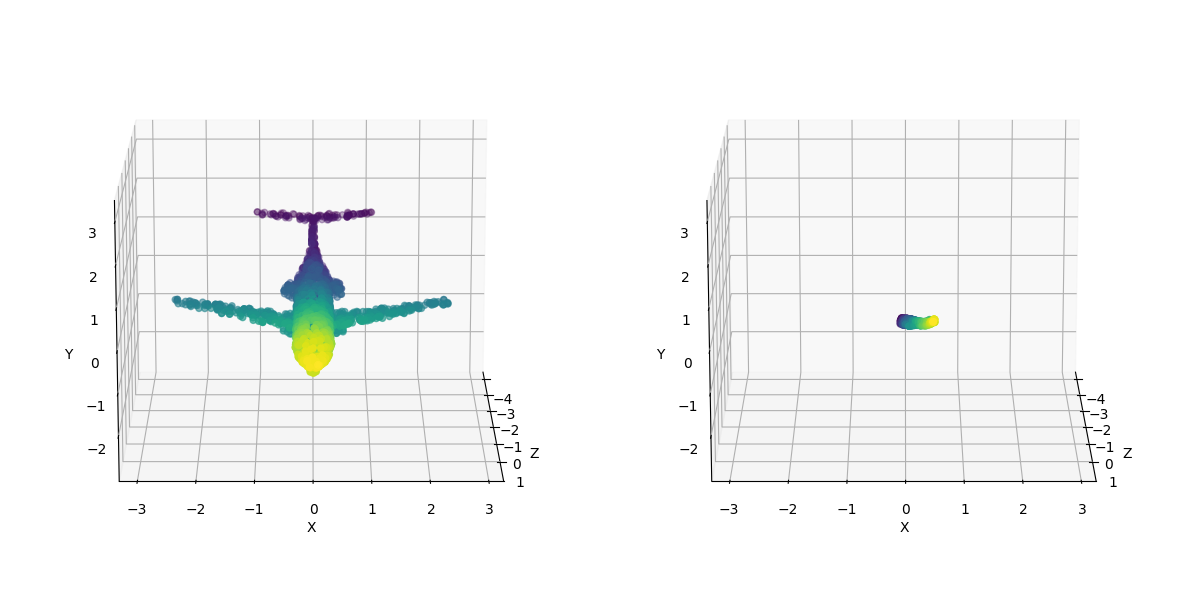

In [62]:
test_batch = test_batch.cpu()
test_output_batch = test_output_batch.cpu()
visualize_pointcloud_eval(test_batch[0].squeeze(), (test_batch + test_output_batch)[0].squeeze())
visualize_pointcloud_eval(test_batch[0].squeeze(), (test_output_batch)[0].squeeze())